<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/05_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
iris = load_iris(as_frame=True)

This 'iris' is of type 'Bunch' which is a collection of data.
Next, we look at .data and .target_name which are of type DataFrame and Series.

In [3]:
iris.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Here is the list of correspondence in the 'target' series:

- 0 -> setosa
- 1 -> versicolor
- 2 -> virginica

Because we are only interested in 'virginica' type, we create a new target series with binary classes. <br>
We use .target to create the binary targets.


In [5]:
X = iris.data[['petal length (cm)', 'petal width (cm)']].values # this conerts pandas.DataFramr to numoy.ndarray
y = (iris.target == 2)

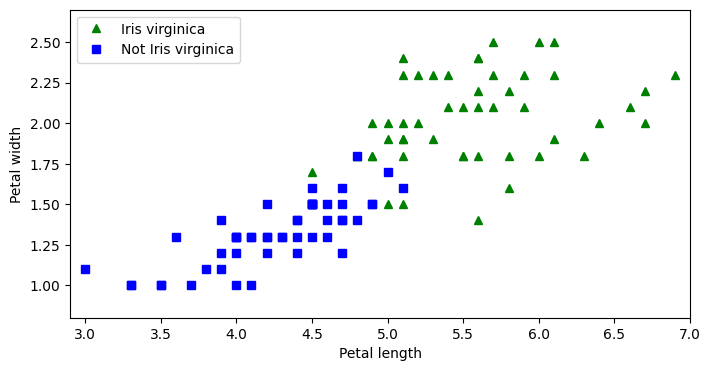

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(X[:, 0][y], X[:, 1][y], "g^", label="Iris virginica")
plt.plot(X[:, 0][~y], X[:, 1][~y], "bs", label="Not Iris virginica")
plt.xlabel("Petal length", fontsize=10)
plt.ylabel("Petal width", fontsize=10)
plt.legend(loc="upper left", fontsize=10)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

In [65]:
svm_clf1 = make_pipeline(
    StandardScaler(),
    LinearSVC(C=1, random_state=42), # C is a regularization phyperparameter. C=1 creates boundary with wider bandwidth, more margin violation, and higher chance of underfitting.
)
svm_clf1.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [66]:
svm_clf2 = make_pipeline(
    StandardScaler(),
    LinearSVC(C=100, random_state=42), # C is a regularization phyperparameter. C=100 creates boundary with narrower bandwidth, less margin violation, and higher chance of overfitting.
)
svm_clf2.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=100, random_state=42))])

In [10]:
X_new = [[5.5, 1.7], [5.0, 1.5]]

print(svm_clf1.predict(X_new))
print(svm_clf1.decision_function(X_new), end="\n\n")

print(svm_clf2.predict(X_new))
print(svm_clf2.decision_function(X_new))

[ True False]
[ 0.66163411 -0.22036063]

[ True False]
[ 1.2726318  -0.23024015]


In [11]:
scaler = svm_clf1.named_steps['standardscaler']
classifier = svm_clf1.named_steps['linearsvc']

print(f"scaled intercept (b): {classifier.intercept_[0]}")
print(f"scaled coefficients (w): {classifier.coef_[0]}", end="\n\n")

print(f"scaler scale: {scaler.scale_}")
print(f"scaler mean: {scaler.mean_}", end="\n\n")

scaled intercept (b): -1.9704759578221047
scaled coefficients (w): [1.52204565 1.70721527]

scaler scale: [1.75940407 0.75969263]
scaler mean: [3.758      1.19933333]



Here is how to convert the scaled coeeficient and intercept to unscaled ones:<br>

$ y_s = w_s X_s + b_s \tag{1}$ <br>
$ y = w X + b \tag{2}$<br>

where subscript $s$ indicates the scaled parameters and <br>

$ X_s = \cfrac{X - \bar{X}}{\mu} \rightarrow X = \mu X_s + \bar{X} \tag{3}$ <br>

where $\bar{X}$ and $\mu$ are mean and standard deviation of X respectively. Our goal is find $w$ and $b$ in terms of $w_s$ and $b_s$. Substituting $X$ in $(2)$ with the one in $(3)$ will result in <br>

$ y = w (\mu X_s + \bar{X}) + b \tag{4}$ <br>
$ y = (w \mu) X_s + (w \bar{X} + b) \tag{5}$ <br>

Comparing $(5)$ with $(1)$, we can conclude that <br>

$ w_s = w \mu → w = \cfrac{w_s}{\mu} \tag{6} $ <br>

and

$ b_s = w \bar{X} + b → b = - w \bar{X} + b_s \tag{7} $ <br>

After substituting $w$ in $(7)$ with the one in $(6)$ and rearrangement, we will have <br>

$ b = w_s \left( -\cfrac{\bar{X}}{\mu} \right) + b_s \tag{8} $ <br>

This means we can compute $b$ using `.decision_function()` with $-\frac{\bar{X}}{\mu}$ as its input.

In [12]:
print(f"unscaled coefficients (w): {classifier.coef_ / scaler.scale_}")
print(f"unscaled intercept (b): {svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])}")

unscaled coefficients (w): [[0.86509158 2.24724474]]
unscaled intercept (b): [-13.3122232]


In [13]:
[-scaler.mean_ / scaler.scale_]

[array([-2.1359505 , -1.57870866])]

In [19]:
svm_clf1.decision_function([[0, 0]])

array([-7.91668565])

In [20]:
svm_clf1.named_steps['linearsvc'].coef_.T @ [-scaler.mean_ / scaler.scale_] + svm_clf1.named_steps['linearsvc'].intercept_

array([[-5.22149012, -4.37334261],
       [-5.61700326, -4.66567149]])

Note that at the decision boundary <br>

$ y = w X + b = 0 \tag{9}$
$ w_0 x_0 + w_1 x_1 + b = 0 \tag{10} $
$ x_1 = \left( - \frac{w_0}{w_1} \right) x_0 - \frac{b}{w_1} \tag{11} $

where $x_0$ is the petal length and $x_1$ is the petal width.

In [67]:
def get_unscaled_params(svm_clf):
    scaler = svm_clf.named_steps['standardscaler']
    classifier = svm_clf.named_steps['linearsvc']

    # Scaled coefficients and intercept
    w_s = classifier.coef_[0]
    b_s = classifier.intercept_[0]

    # Unscaled coefficients and intercept
    w = w_s / scaler.scale_
    b = classifier.decision_function([-scaler.mean_ / scaler.scale_])

    return w, b

In [68]:
def plot_svc_decision_boundary(ax, svm_clf, xmin, xmax):
    # Unscaled coefficients and intercept
    w, b = get_unscaled_params(svm_clf)

    # Generate unscaled x0 and x1 for plotting
    x0 = np.linspace(xmin, xmax, 200)
    x1 = -(w[0] / w[1]) * x0 - b / w[1]

    ax.plot(x0, x1, "k-", linewidth=2, zorder=-2)

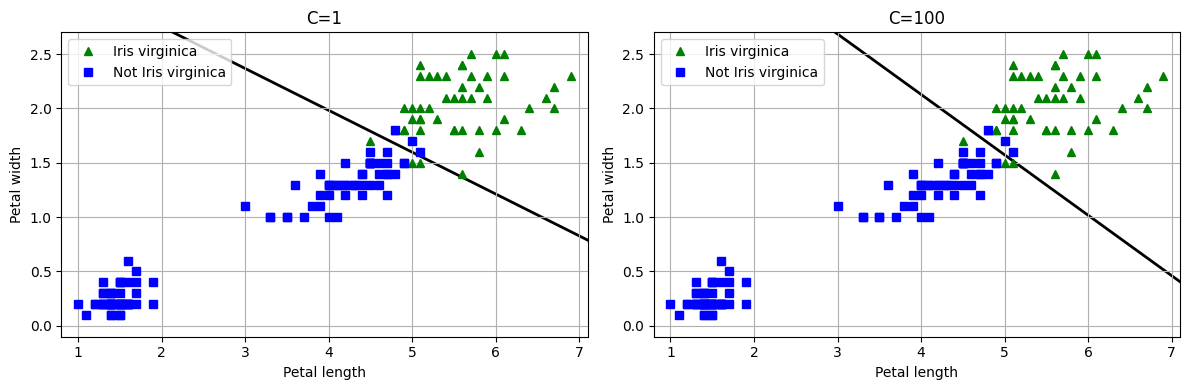

In [69]:
x0_min = X[:, 0].min() - 0.2
x0_max = X[:, 0].max() + 0.2

x1_min = X[:, 1].min() - 0.2
x1_max = X[:, 1].max() + 0.2

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # 1 row, 2 columns

# Plot on the left subplot (svm_clf1 with C=1)
ax1.plot(X[:, 0][y], X[:, 1][y], "g^", label="Iris virginica")
ax1.plot(X[:, 0][~y], X[:, 1][~y], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(ax1, svm_clf1, x0_min, x0_max)
ax1.set_title('C=1')
ax1.set_xlabel("Petal length", fontsize=10)
ax1.set_ylabel("Petal width", fontsize=10)
ax1.legend(loc="upper left", fontsize=10)
ax1.set_xlim(x0_min, x0_max)
ax1.set_ylim(x1_min, x1_max)
ax1.grid()

# Plot on the second subplot
ax2.plot(X[:, 0][y], X[:, 1][y], "g^", label="Iris virginica")
ax2.plot(X[:, 0][~y], X[:, 1][~y], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(ax2, svm_clf2, x0_min, x0_max)
ax2.set_title('C=100')
ax2.set_xlabel("Petal length", fontsize=10)
ax2.set_ylabel("Petal width", fontsize=10)
ax2.legend(loc="upper left", fontsize=10)
ax2.set_xlim(x0_min, x0_max)
ax2.set_ylim(x1_min, x1_max)
ax2.grid()

plt.tight_layout()
plt.show()

In [71]:
def get_support_vectors(svm_clf, X, y):
    # Unscaled coefficients and intercept
    w, b = get_unscaled_params(svm_clf)

    # Compute decision function for each sample X
    decision_boundary = X.dot(w) + b

    # Convert binary class labels 'y' from {0, 1} to {-1, 1}
    # SVM formulation typically uses labels {-1, 1}
    t = y * 2 - 1

    # Identify support vector indices for classifier
    # 't * decision_boundary' scales the decision boundary by the corresponding label in 't'
    # '<1' condition checks which samples are within the margin or on the wrong side of the decision boundary
    support_vector_indices = (t * decision_boundary < 1).ravel()

    # Get support vectors
    support_vectors = X[support_vector_indices]

    return support_vectors

In [82]:
def plot_svc_decision_boundary_with_margins(ax, svm_clf, X, y):
    # Unscaled coefficients and intercept
    w, b = get_unscaled_params(svm_clf)

    # Generate unscaled x0 and x1 for plotting
    xmin = X[:, 0].min() - 0.2
    xmax = X[:, 0].max() + 0.2
    x0 = np.linspace(xmin, xmax, 200)
    x1 = -(w[0] / w[1]) * x0 - b / w[1]

    # Generate margins
    margin = 1 / w[1]
    gutter_up = x1 + margin
    gutter_down = x1 - margin

    # Support vectors
    svs = get_support_vectors(svm_clf, X, y)

    ax.plot(x0, x1, "k-", linewidth=2, zorder=-2)
    ax.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    ax.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    ax.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFBB00')

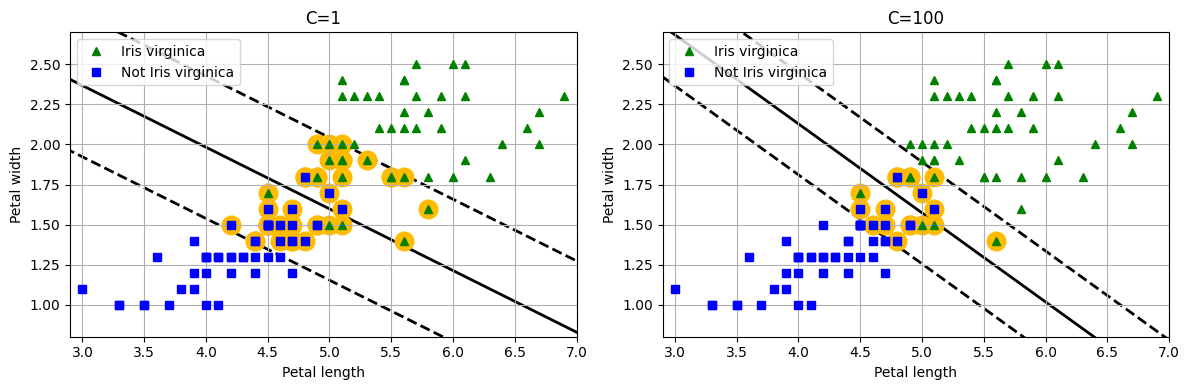

In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # 1 row, 2 columns

# Plot on the left subplot (svm_clf1 with C=1)
ax1.plot(X[:, 0][y], X[:, 1][y], "g^", label="Iris virginica")
ax1.plot(X[:, 0][~y], X[:, 1][~y], "bs", label="Not Iris virginica")
plot_svc_decision_boundary_with_margins(ax1, svm_clf1, X, y)
ax1.set_title('C=1')
ax1.set_xlabel("Petal length", fontsize=10)
ax1.set_ylabel("Petal width", fontsize=10)
ax1.legend(loc="upper left", fontsize=10)
ax1.set_xlim(2.9, 7)
ax1.set_ylim(.8, 2.7)
ax1.grid()

# Plot on the second subplot
ax2.plot(X[:, 0][y], X[:, 1][y], "g^", label="Iris virginica")
ax2.plot(X[:, 0][~y], X[:, 1][~y], "bs", label="Not Iris virginica")
plot_svc_decision_boundary_with_margins(ax2, svm_clf2, X, y)
ax2.set_title('C=100')
ax2.set_xlabel("Petal length", fontsize=10)
ax2.set_ylabel("Petal width", fontsize=10)
ax2.legend(loc="upper left", fontsize=10)
ax2.set_xlim(2.9, 7)
ax2.set_ylim(.8, 2.7)
ax2.grid()

plt.tight_layout()
plt.show()

Now, let's use `SVC` with `kernel='linear'` instead of `LinearSVC` as the classifier. This way we don't need to compute the support vectors manually.

In [84]:
# TODO: SVC classifier instead of LinearSVC